## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [72]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [73]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [74]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [75]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [76]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [77]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [78]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [79]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [80]:
target = 'survived'

In [81]:
vars_num = [var for var in data if data[var].dtypes != 'O']# fill your code here

vars_cat = [var for var in data if data[var].dtypes == 'O']# fill your code here

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 6
Number of categorical variables: 4


### Find missing values in variables

In [82]:
# first in numerical variables
vars_num_na = [var for var in vars_num if data[var].isnull().sum() > 0 and data[var].dtypes != 'O']
data[vars_num_na].isnull().mean()

age     0.200917
fare    0.000764
dtype: float64

In [83]:
# now in categorical variables
vars_cat_na = [var for var in vars_cat if data[var].isnull().sum() > 0 and data[var].dtypes == 'O']
data[vars_cat_na].isnull().mean()

cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

In [84]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

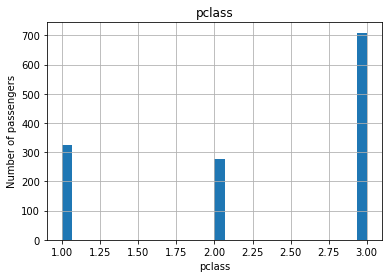

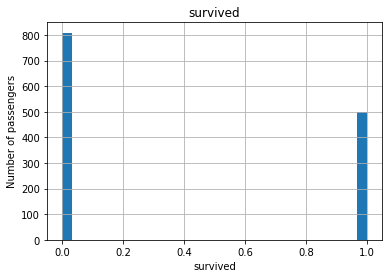

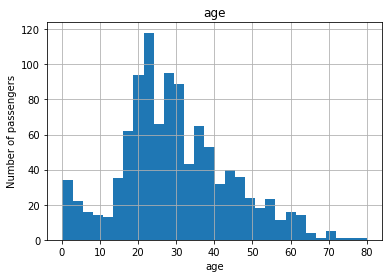

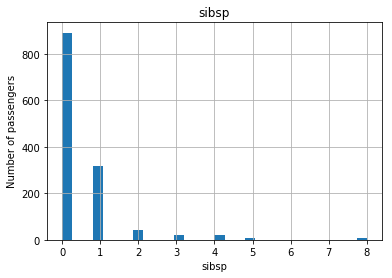

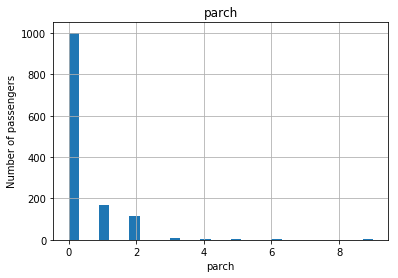

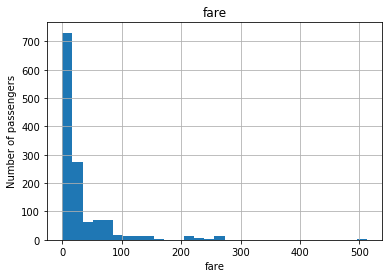

In [85]:
def analyse_continuous(df, var):
    df = df.copy()
    df[var].hist(bins=30)
    plt.ylabel('Number of passengers')
    plt.xlabel(var)
    plt.title(var)
    plt.show()


for var in vars_num:
    analyse_continuous(data, var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [87]:
data['cabin'] = data['cabin'].str[0]
X_train['cabin'] = X_train['cabin'].str[0]
X_test['cabin'] = X_test['cabin'].str[0]
data['cabin'].nunique()

8

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [88]:
# make a list with the numerical variables that contain missing values
vars_with_na = [var for var in X_train.columns
                if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O']

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

age     0.196753
fare    0.000955
dtype: float64

In [89]:
# replace engineer missing values as we described above

for var in vars_with_na:

    # calculate the median using the train set
    median_val = X_train[var].median()

    # add binary missing indicator (in train and test)
    X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mode
    # (in train and test)
    X_train[var] = X_train[var].fillna(median_val)
    X_test[var] = X_test[var].fillna(median_val)

# check that we have no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [90]:
# make a list of the categorical variables that contain missing values
vars_with_na = [
    var for var in X_train.columns
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

cabin       0.766953
embarked    0.001910
dtype: float64

In [91]:
# replace missing values with new label: "Missing"

X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [92]:
# check that we have no missing information in the engineered variables
X_train[vars_with_na].isnull().sum()

cabin       0
embarked    0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [93]:
# let's capture the categorical variables in a list
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
cat_vars

['sex', 'cabin', 'embarked', 'title']

In [94]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var).size() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [95]:
def One_hot_encoding(data):
    
    cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
    df = pd.get_dummies(data, prefix_sep="_",columns=cat_vars)
    columns = df.columns
    data[columns] = df
    data.drop(cat_vars,axis=1,inplace = True)
    return(data)


In [97]:
#combining the tsest and train data so that dummy variables get created for all the categories
X_train['tag'] = 1
X_test['tag'] = 0
df = pd.concat([X_train,X_test])

In [102]:
#Creating dummy variables using the derived function and then splitting the data into traiin and test
df = One_hot_encoding(df)
X_train = df[df['tag'] == 1]
X_test = df[df['tag'] == 0]

X_train.drop('tag', axis = 1)
X_test.drop('tag', axis = 1)

print(X_test.shape,X_train.shape)

(262, 20) (1047, 20)


### Scale the variables

- Use the standard scaler from Scikit-learn

In [103]:
train_vars = X_train.columns
print(X_train.head())
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 

# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])

X_test[train_vars] = scaler.transform(X_test[train_vars])

      pclass   age  sibsp  parch      fare  age_na  fare_na  tag  sex_female  \
1118       3  25.0      0      0    7.9250       0        0    1           0   
44         1  41.0      0      0  134.5000       0        0    1           1   
1072       3  28.0      0      0    7.7333       1        0    1           0   
1130       3  18.0      0      0    7.7750       0        0    1           1   
574        2  29.0      1      0   21.0000       0        0    1           0   

      sex_male  cabin_C  cabin_Rare  embarked_C  embarked_Q  embarked_Rare  \
1118         1        0           1           0           0              0   
44           0        0           1           1           0              0   
1072         1        0           1           0           1              0   
1130         0        0           1           0           0              0   
574          1        0           1           0           0              0   

      embarked_S  title_Miss  title_Mr  title_Mrs 

C:\Users\Nilesh3030\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Nilesh3030\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Nilesh3030\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [112]:
clf = LogisticRegression(random_state=0, C = 0.0005).fit(X_train, y_train)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [117]:
roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
score = accuracy_score(y_test,clf.predict(X_test))
roc,score

(0.8350308641975309, 0.7862595419847328)

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**